In [1]:
import pandas as pd
import sqlite3 as sq
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, re
import nltk
from IPython.display import Image
import datetime
from collections import Counter
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 1000)

df = pd.read_csv('transactions.csv')

In [2]:
labels = pd.read_excel('healthiness_annotations.xlsx')

dict_h = {}
for i,name in enumerate(labels['product'].values):
    dict_h[name] = labels['healthiness'].values[i]

dict_s = {}
for i,name in enumerate(labels['product'].values):
    dict_s[name] = labels['saltiness'].values[i]

In [3]:
def get_fraction_unhealthy_prod(purchases):
    h = 0
    un = 0
    
    for item in purchases:
        if item in dict_h.keys():
            if dict_h[item] == 1:
                un+=1
            elif dict_h[item] == 0:
                h+=1
    if h+un == 0:
        return np.nan
    else:
        return((un)/(h+un))

In [7]:
df_sample = df.loc[(df['u_day']>20100000) & (df['u_day']<20180100)]


start = datetime.datetime.strptime("31-12-2009", "%d-%m-%Y")
end = datetime.datetime.strptime("02-01-2018", "%d-%m-%Y")
dates_observed = [start + datetime.timedelta(days=x) for x in range(0, (end-start).days)]    


low_b = np.empty((len(dates_observed)))
low_b[:] = np.nan

up_b = np.empty((len(dates_observed)))
up_b[:] = np.nan

est = np.empty((len(dates_observed)))
est[:] = np.nan



In [8]:
def find_date(entry):
    count = np.nan
    for count,date_temp in enumerate(dates_observed):
        if date_temp.year == pd.to_datetime(entry).year and \
        date_temp.month == pd.to_datetime(entry).month and \
        date_temp.day == pd.to_datetime(entry).day:
            return count
            break

In [9]:
for name,group in df_sample.groupby('u_day'):
    if name % 10 == 0:
        print(name)
        
    position = find_date(group.iloc[0]['TRANSACTIONDETAILDATE'])
    
    if dates_observed[position].weekday()<5:
        if not np.isnan((get_fraction_unhealthy_prod(group['lowname'].values))):
            low_b[position] = get_fraction_unhealthy_prod_upper_bound(group['lowname'].values)
            est[position] = get_fraction_unhealthy_prod(group['lowname'].values)
            up_b[position] = get_fraction_unhealthy_prod_lower_bound(group['lowname'].values)


20100110
20100120
20100130
20100210
20100220
20100310
20100320
20100330
20100410
20100420
20100430
20100510
20100520
20100530
20100610
20100620
20100630
20100710
20100720
20100730
20100810
20100820
20100830
20100910
20100920
20100930
20101020
20101030
20101110
20101120
20101130
20101210
20101220
20101230
20110110
20110120
20110210
20110310
20110330
20110410
20110420
20110430
20110510
20110520
20110530
20110610
20110620
20110630
20110710
20110720
20110730
20110810
20110820
20110830
20110910
20110920
20110930
20111010
20111020
20111030
20111110
20111120
20111130
20111210
20111220
20111230
20120110
20120120
20120130
20120210
20120220
20120310
20120320
20120330
20120410
20120420
20120430
20120510
20120520
20120530
20120610
20120620
20120630
20120710
20120720
20120730
20120810
20120820
20120830
20120910
20120920
20120930
20121010
20121020
20121030
20121110
20121120
20121130
20121210
20121220
20130110
20130120
20130130
20130210
20130220
20130310
20130320
20130330
20130410
20130420
20130430
2

In [43]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

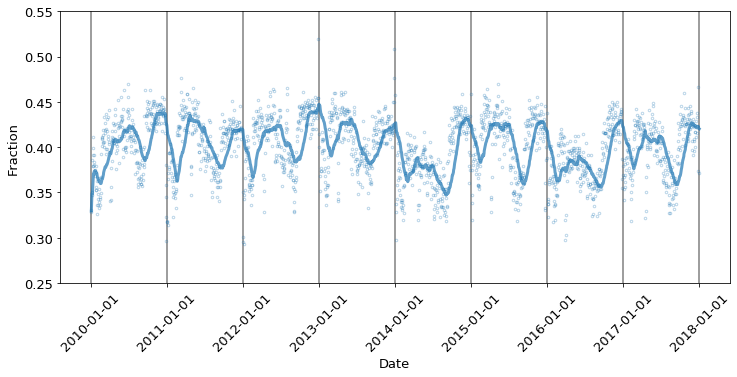

In [44]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(1,1,figsize= (12,5))

ax.plot(est,linestyle = 'none',marker = 'o', alpha = 0.3,markersize= 2.5, fillstyle='none',color = 'tab:blue')

ax.set_xticks([cnt for cnt,date in enumerate(dates_observed) if date.day == 1 and (date.month ==1)])
ax.set_xticklabels([str(date)[:10] for cnt,date in enumerate(dates_observed) if date.day == 1 and (date.month ==1 )],rotation = 45);

smoothed = pd.DataFrame(est).rolling(60, min_periods = 2).mean()

ax.plot(smoothed, color = 'tab:blue', linewidth = 3, alpha = 0.7)
ax.vlines([cnt for cnt,date in enumerate(dates_observed) if date.day == 1 and (date.month ==1)],ymin = 0.2,ymax =0.6,color = 'tab:gray')
ax.set_ylabel('Fraction')
ax.set_xlabel('Date')

ax.set_ylim([0.25,0.55])

plt.savefig("seasonality.pdf", bbox_inches='tight')